En primer lugar, se implementan las librerias genericas que se utilizan

In [1]:
import numpy as np
from scipy import optimize as opt

import os
print(os.getcwd())

c:\Users\pablomaga\Documents\GitHub\Trabajo-MNP


A continuacion, se importa el codigo creado

In [2]:
from src import Airplane

Creacion del objeto del ala

In [3]:
pedro = Airplane(1000, 15)

In [4]:
print(pedro.lift_poli_fortran(4, [1.4,2,3]))
print(pedro.lift_poli([1,2,3]))

print(pedro.moment_poli_fortran(4, [1.4,2,3]))
print(pedro.moment_poli([1.4,2,3]))

0.7853981633974483
0.7853981633974487
14.431691252428111
14.431691251990035


La funcion `lift_difference` permite calcular la diferencia entre el lift que genera el ala y la fuerza generada en valor absoluto. Cuanto mayor sea este valor, mas proporcion de fuerza hacia abajo se esta realizando y, por tanto, menos eficiente es el ala, pues está gastando energia en generar fuerza hacia abajo en lugar de hacia arriba.

In [5]:
def lift_difference(a):
    return abs((pedro.lift_poli(a) - pedro.abs_lift(a))/(pedro.abs_lift(a)+1))

Por ejemplo, en caso de utilizar el polinomio x^2 + 2x, se obtiene lo siguiente:

In [6]:
print(lift_difference([1, 2]))

0.04294156977359735


En la optimizacion, se pueden controlar principalmente los siguientes parametros

In [7]:
grado = 4 # Gradio del polinonio g(x) en la funcion f(x) = sqrt(1-x^2) * g(x)

lift = pedro.weight/2 # [N] Fuerza de sustentacion objetivo en el ala (la mitad del peso del avion)
lift_tol = 0.1 # Tolerancia de la fuerza de sustentacion

negative_lift_tol = 0.1 # Tolerancia de la fuerza de sustentacion negativa

In [8]:
# Funcion objetivo, minimizar el momento de la fuerza de sustentacion
def objective(a):
    return abs(pedro.moment_poli(a))

# Se restringe la fuerza de sustentacion a un rango de tolerancia
lift_target = opt.NonlinearConstraint(lambda a: pedro.lift_poli(a), lift*(1-lift_tol), lift*(1+lift_tol))

# Se restringe la cantidad de fuerza de sustentacion negativa a un rango de tolerancia
negative_lift = opt.NonlinearConstraint(lift_difference, 0, negative_lift_tol)


a0 = np.zeros(grado)
print(f"Coeficientes inciales: {a0}")
print("-------------------------")

res = opt.minimize(objective, a0, method='SLSQP', constraints=[lift_target, negative_lift], options={'disp': True})

res = res.x
print("-------------------------")
print(f"Coeficientes finales: {res}")


Coeficientes inciales: [0. 0. 0. 0.]
-------------------------


c:\Users\pablomaga\Documents\GitHub\Trabajo-MNP\src\airplane\airplane.py:142: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Args:


Optimization terminated successfully    (Exit mode 0)
            Current function value: 5721.737008662069
            Iterations: 54
            Function evaluations: 331
            Gradient evaluations: 53
-------------------------
Coeficientes finales: [  1394.53226729   1602.10328198 -21363.60113136  19255.73900563]


Finalmente, se muestra el lift obtenido, el momento en la raiz, la grafica del lift en funcion de la posicion y el momento en la raiz

Lift total obtenido: 4410.000000088869 N
Momento en la raiz: 5721.737008662069 N*m


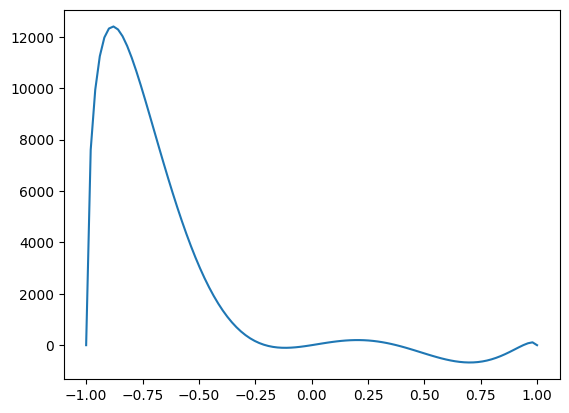

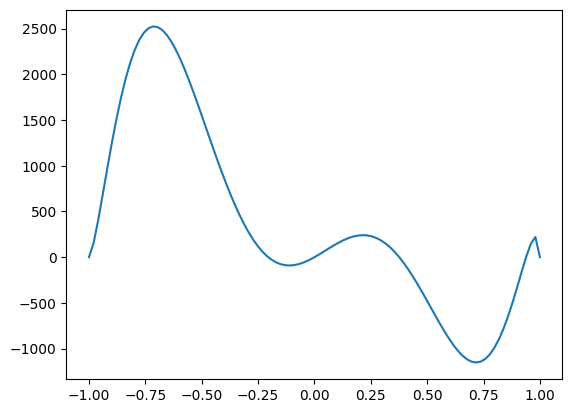

In [9]:
print(f"Lift total obtenido: {pedro.lift_poli(res)} N")
print(f"Momento en la raiz: {pedro.moment_poli(res)} N*m")


pedro.plot_lift(res)
pedro.plot_moment(res)

Ejemplo de como se llama a una funcion de fortran para calcular los nodos de chebyshev

In [10]:
from src import gauss_chebyshev as gc
from time import time
import numpy as np
import math

In [11]:
ejecuciones = 6000000

In [17]:
t0 = time()
gc.chebyshev_nodes(ejecuciones)
print("Tiempo de ejecución: ", time()-t0)

Tiempo de ejecución:  0.20017099380493164


Aqui se ve que usando operaciones vectoriales es muchisimo mas rapido, que es lo que se deberia utilizar en fortran

In [13]:
def chebyshev_nodes(n):
    """
    Cálculo de los nodos y pesos de Chebyshev.
    
    :param n: número de nodos
    :return: (x, w) tupla de dos arrays de longitud n
             x -> nodos de Chebyshev
             w -> pesos (constantes en este caso)
    """
    # Generamos un array con valores i = 1, 2, ..., n
    i = np.arange(1, n + 1)

    # Cálculo de los nodos x(i) = cos( (2*i - 1)*pi / (2*n) )
    x = np.cos((2.0 * i - 1.0) * np.pi / (2.0 * n))

    # Cálculo de los pesos w(i) = pi / n (constante)
    w = np.full(n, np.pi / n)  # Crea un array de tamaño n con el mismo valor

    return x, w

# Ejemplo de uso
if __name__ == "__main__":
    t0 = time()
    x, w = chebyshev_nodes(ejecuciones)
    print("Tiempo de ejecución: ", time()-t0)



Tiempo de ejecución:  0.06634974479675293


Usando un bucle de Python y la libreria math (hecha en C), se ve que es extremadamente lento

In [14]:


def chebyshev_nodes(n):
    """
    Cálculo de los nodos y pesos de Chebyshev (versión sin NumPy).
    
    :param n: número de nodos
    :return: (x, w) tupla de dos listas de longitud n
             x -> nodos de Chebyshev
             w -> pesos (constantes en este caso)
    """
    x = []
    w = []
    
    for i in range(1, n + 1):
        # x(i) = cos((2*i - 1)*pi / (2*n))
        x_val = math.cos((2.0 * i - 1.0) * math.pi / (2.0 * n))
        x.append(x_val)
        
        # w(i) = pi / n
        w_val = math.pi / n
        w.append(w_val)
    
    return x, w

# Ejemplo de uso
if __name__ == "__main__":
    t0 = time()
    x, w = chebyshev_nodes(ejecuciones)
    print("Tiempo de ejecución: ", time()-t0)


Tiempo de ejecución:  0.8023099899291992
